In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/users-vs-bots-classification/bots_vs_users.csv


# 🧾 Final Analysis Summary

## 📊 Project Overview

This project focuses on classifying **users vs. bots** using profile and behavioral data from a social media dataset. We explored 60 original features (59 predictors + 1 target) to understand how bots and users differ, reduced the number of predictors using SHAP, and trained an XGBoost classifier to achieve near-perfect performance.

---

## 📉 Feature Selection Summary

We began with **60 total columns**, consisting of **1 target variable** and **59 predictors**. After training an initial XGBoost model using all predictors, we applied **SHAP (SHapley Additive exPlanations)** to interpret feature importance and identify the most impactful variables.

Through this analysis, we successfully reduced the feature space down to **17 core predictors** without sacrificing model performance — maintaining F1 scores of **0.98 on training/validation** and **0.97 on test**. This dimensionality reduction improved interpretability and efficiency while retaining predictive power.

The `city` column was intentionally excluded from training due to its **high cardinality** — many unique values with low repetition across records. Including it would have inflated the feature space and potentially introduced noise or overfitting without clear benefit.

---

## 🧠 Behavioral Insights

**Bots** typically exhibit **high activity patterns**:
- Lower `subscribers_count`
- Higher `posting_frequency_days`
- More `avg_views`, `posts_count`, and `reposts_ratio`
- More likely to have **all posts visible**
- Often **lack a display photo**, yet overfill profile fields such as `has_nickname`, `has_maiden_name`, and `has_status`

These patterns suggest automated, template-based profile behavior meant to simulate user authenticity.

**Real users**, on the other hand:
- Show more **moderate activity** and **authentic profile behavior**
- Tend to include fields like `has_photo`, `has_mobile`, `has_occupation`, and `occupation_type_university`
- Are more likely to leave optional fields blank, which actually signals human-like randomness and selectivity

---

## 📈 SHAP Feature Importance Insights

Key features differentiating bots from users (from SHAP analysis):
- `occupation_type_university`
- `has_photo`
- `posting_frequency_days`
- `subscribers_count`
- `reposts_ratio`
- `avg_views`
- `has_status`
- `has_nickname`

These features contributed most to the model’s decision-making process, aligning with the behavioral trends observed in EDA.

---

## 🧪 Model Performance

We used a **60% train**, **20% validation**, and **20% test** split. After tuning with Optuna and training XGBoost:

| Dataset         | F1 - User Class | F1 - Bot Class |
|-------------|----------|----------|
| Train       | 0.98     | 0.98     |
| Validation  | 0.98     | 0.98     |
| Test        | 0.97     | 0.96     |

- The model demonstrates **high precision and recall** on both classes.
- Results are **balanced and consistent**, indicating **robust generalization**.
- We can **accurately and precisely distinguish users from bots** in production scenarios.

---

## ✅ Summary

Through exploratory analysis, model interpretability (SHAP), and rigorous training, we established a reliable foundation for classifying users vs. bots using behavioral and profile signals. The model is highly accurate, interpretable, and efficient — ready for deployment or further experimentation with additional signals such as content-based or temporal features.


In [2]:
import optuna
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import optuna
import shap
import logging
import warnings
import matplotlib.pyplot as plt
import math

warnings.filterwarnings("ignore", category=RuntimeWarning)
optuna.logging.set_verbosity(logging.WARNING)

In [3]:
df=pd.read_csv('/kaggle/input/users-vs-bots-classification/bots_vs_users.csv')
df.head()

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown


In [4]:
cols_w_nulls =['posts_count', 'avg_likes', 'links_ratio',
       'hashtags_ratio', 'avg_keywords', 'avg_text_length',
       'attachments_ratio', 'avg_comments', 'reposts_ratio', 'ads_ratio',
       'avg_views', 'posting_frequency_days', 'phone_numbers_ratio',
       'avg_text_uniqueness']
df[cols_w_nulls].sample(10)

,posts_count,avg_likes,links_ratio,hashtags_ratio,avg_keywords,avg_text_length,attachments_ratio,avg_comments,reposts_ratio,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness
4233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1413,20.0,0.0,0.2,0.15,11.1,1186.4,0.95,0.0,1.0,0.0,0.25,0.01,0.0,0.64
2424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean Data

In [5]:
# Replace 'Unknown' (case-insensitive) with NaN across all columns except 'city'
for col in df.columns:
    if col == 'city':
        continue
    df[col] = df[col].apply(lambda x: np.nan if isinstance(x, str) and x.strip().lower() == 'unknown' else x)


In [6]:
df = df.fillna(-999)

In [7]:
df['target'].value_counts()


target
1    2937
0    2937
Name: count, dtype: int64

# Train Test Split

In [8]:

X = df.drop(columns=['target', 'city']).apply(pd.to_numeric, errors='coerce').fillna(-999)

# Most Relevant features
top_17_features = ['has_status',
                   'subscribers_count',
                   'has_occupation',
                   'has_website',
                   'posting_frequency_days',
                   'has_birth_date',
                   'has_nickname',
                   'gender',
                   'access_to_closed_profile',
                   'avg_views',
                   'has_mobile',
                   'has_photo',
                   'posts_count',
                   'has_maiden_name',
                   'occupation_type_university',
                   'reposts_ratio',
                   'all_posts_visible']

X = X[top_17_features]

y = df['target']

# Split 1: 80% train-val, 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)

# Split 2: From trainval: 60% train, 20% val of full dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=123
)

# Hyperparameter Tuning - Optuna

In [9]:

def objective(trial):

    num_boost_round = trial.suggest_int("num_boost_round", 500, 5000, step=250)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': 1.0,
        'seed': 123
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dval, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = model.predict(dval)
    score = roc_auc_score(y_val, preds)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, timeout=None)




# Model Training + Best Parameters

In [10]:
best_params = study.best_trial.params.copy()
num_boost_round = best_params.pop("num_boost_round")
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 123
})

# Train with column names
dfull = xgb.DMatrix(X_trainval, label=y_trainval, feature_names=X_trainval.columns.tolist())
dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())

final_model = xgb.train(
    best_params,
    dfull,
    num_boost_round=num_boost_round
)

print(best_params)

{'eta': 0.24482762641374706, 'max_depth': 7, 'subsample': 0.8068994984271946, 'colsample_bytree': 0.7304533736058515, 'lambda': 1.5179556338860312e-07, 'alpha': 6.705006510050772, 'min_child_weight': 1, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 123}


# Predictions + Results

In [11]:
dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
dval = xgb.DMatrix(X_val, feature_names=X_val.columns.tolist())

pred_train = (final_model.predict(dtrain) > 0.5).astype(int)
pred_val = (final_model.predict(dval) > 0.5).astype(int)
pred_test = (final_model.predict(dtest) > 0.5).astype(int)

# ────────────────────────────────
# Step 6: Evaluate results
# ────────────────────────────────
print("Train Results:")
print(classification_report(y_train, pred_train))

print("\nValidation Results:")
print(classification_report(y_val, pred_val))

print("\nTest Results:")
print(classification_report(y_test, pred_test))

print("\nBest Trial:")
print(f"AUC: {study.best_value}")
print("Params:", study.best_trial.params)


Train Results:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1762
           1       0.98      0.98      0.98      1762

    accuracy                           0.98      3524
   macro avg       0.98      0.98      0.98      3524
weighted avg       0.98      0.98      0.98      3524


Validation Results:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       587
           1       0.97      0.98      0.98       588

    accuracy                           0.98      1175
   macro avg       0.98      0.98      0.98      1175
weighted avg       0.98      0.98      0.98      1175


Test Results:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       588
           1       0.96      0.98      0.97       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97

# SHAP Explainer

## Explainer Plot

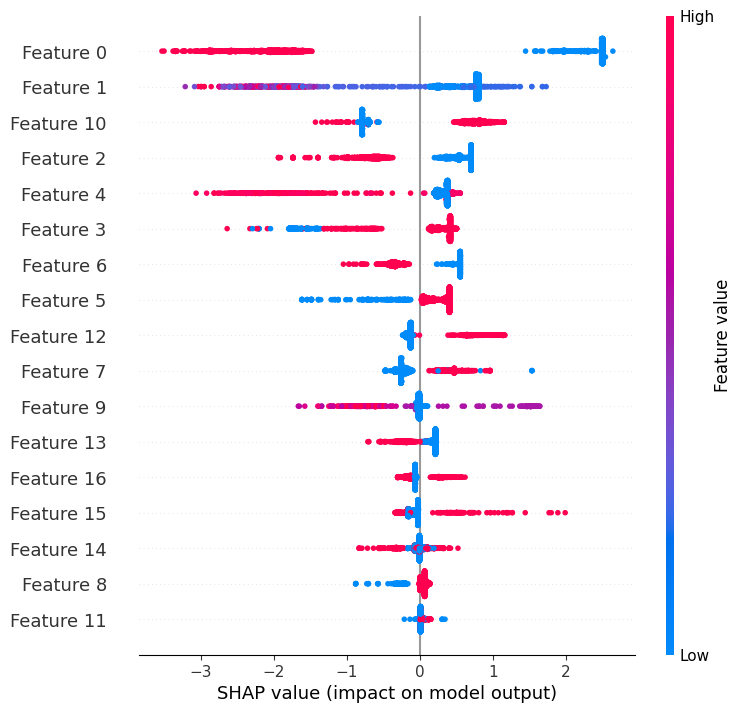

In [12]:
dval_named = xgb.DMatrix(X_val, label=y_val, feature_names=X_val.columns.tolist())

# Generate SHAP values and plot
explainer = shap.Explainer(final_model)
shap_values = explainer(dval_named)
shap.plots.beeswarm(shap_values,max_display=17)


## Top 17 Features

In [13]:
# Get mean absolute SHAP value per feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Pair with feature names
feature_names = shap_values.feature_names
shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': shap_importance
})

# Sort by importance and get top 17
top_17 = shap_df.sort_values(by='mean_abs_shap', ascending=False).head(17).reset_index()

# Convert index to a list of integers
column_indexes = top_17['index'].dropna().astype(int).tolist()

# Get column names from X_val using those indexes
top_17_features = [X_val.columns[i] for i in column_indexes]

top_17_features


['has_status',
 'subscribers_count',
 'has_mobile',
 'has_occupation',
 'posting_frequency_days',
 'has_website',
 'has_nickname',
 'has_birth_date',
 'posts_count',
 'gender',
 'avg_views',
 'has_maiden_name',
 'all_posts_visible',
 'reposts_ratio',
 'occupation_type_university',
 'access_to_closed_profile',
 'has_photo']

# Business Analysis

In [14]:
top_17_features = ['has_status',
                   'subscribers_count',
                   'has_occupation',
                   'has_website',
                   'posting_frequency_days',
                   'has_birth_date',
                   'has_nickname',
                   'gender',
                   'access_to_closed_profile',
                   'avg_views',
                   'has_mobile',
                   'has_photo',
                   'posts_count',
                   'has_maiden_name',
                   'occupation_type_university',
                   'reposts_ratio',
                   'all_posts_visible']
top_17_features

['has_status',
 'subscribers_count',
 'has_occupation',
 'has_website',
 'posting_frequency_days',
 'has_birth_date',
 'has_nickname',
 'gender',
 'access_to_closed_profile',
 'avg_views',
 'has_mobile',
 'has_photo',
 'posts_count',
 'has_maiden_name',
 'occupation_type_university',
 'reposts_ratio',
 'all_posts_visible']

In [15]:
eda_df = X[top_17_features]
eda_df['target'] = y
eda_df.describe()

,has_status,subscribers_count,has_occupation,has_website,posting_frequency_days,has_birth_date,has_nickname,gender,access_to_closed_profile,avg_views,has_mobile,has_photo,posts_count,has_maiden_name,occupation_type_university,reposts_ratio,all_posts_visible,target
count,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000
mean,-503.873000,209.349677,-594.335376,-126.074566,-746.723166,-144.726932,-434.671774,-2.868914,-3.215015,-614.702555,-434.165475,-3.531495,-758.019067,-580.880150,-594.489956,-762.327853,-434.512087,0.500000
std,499.742508,2752.727298,490.868807,331.950211,459.165971,352.862283,495.348673,63.810299,63.787596,1046.598883,495.793082,63.768373,432.658633,492.953334,490.681396,424.917845,495.488938,0.500043
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,-999.000000,-999.000000,-999.000000,0.000000,-999.000000,1.000000,-999.000000,1.000000,1.000000,-999.000000,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,-999.000000,-999.000000,-999.000000,0.000000,-999.000000,1.000000,0.000000,1.000000,1.000000,-999.000000,1.000000,1.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.500000
75%,0.000000,497.000000,1.000000,0.000000,-999.000000,1.000000,0.000000,1.000000,1.000000,-999.000000,1.000000,1.000000,-999.000000,0.000000,0.750000,-999.000000,0.000000,1.000000
max,1.000000,103729.000000,1.000000,1.000000,2866.590000,1.000000,1.000000,2.000000,1.000000,41415.700000,1.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000


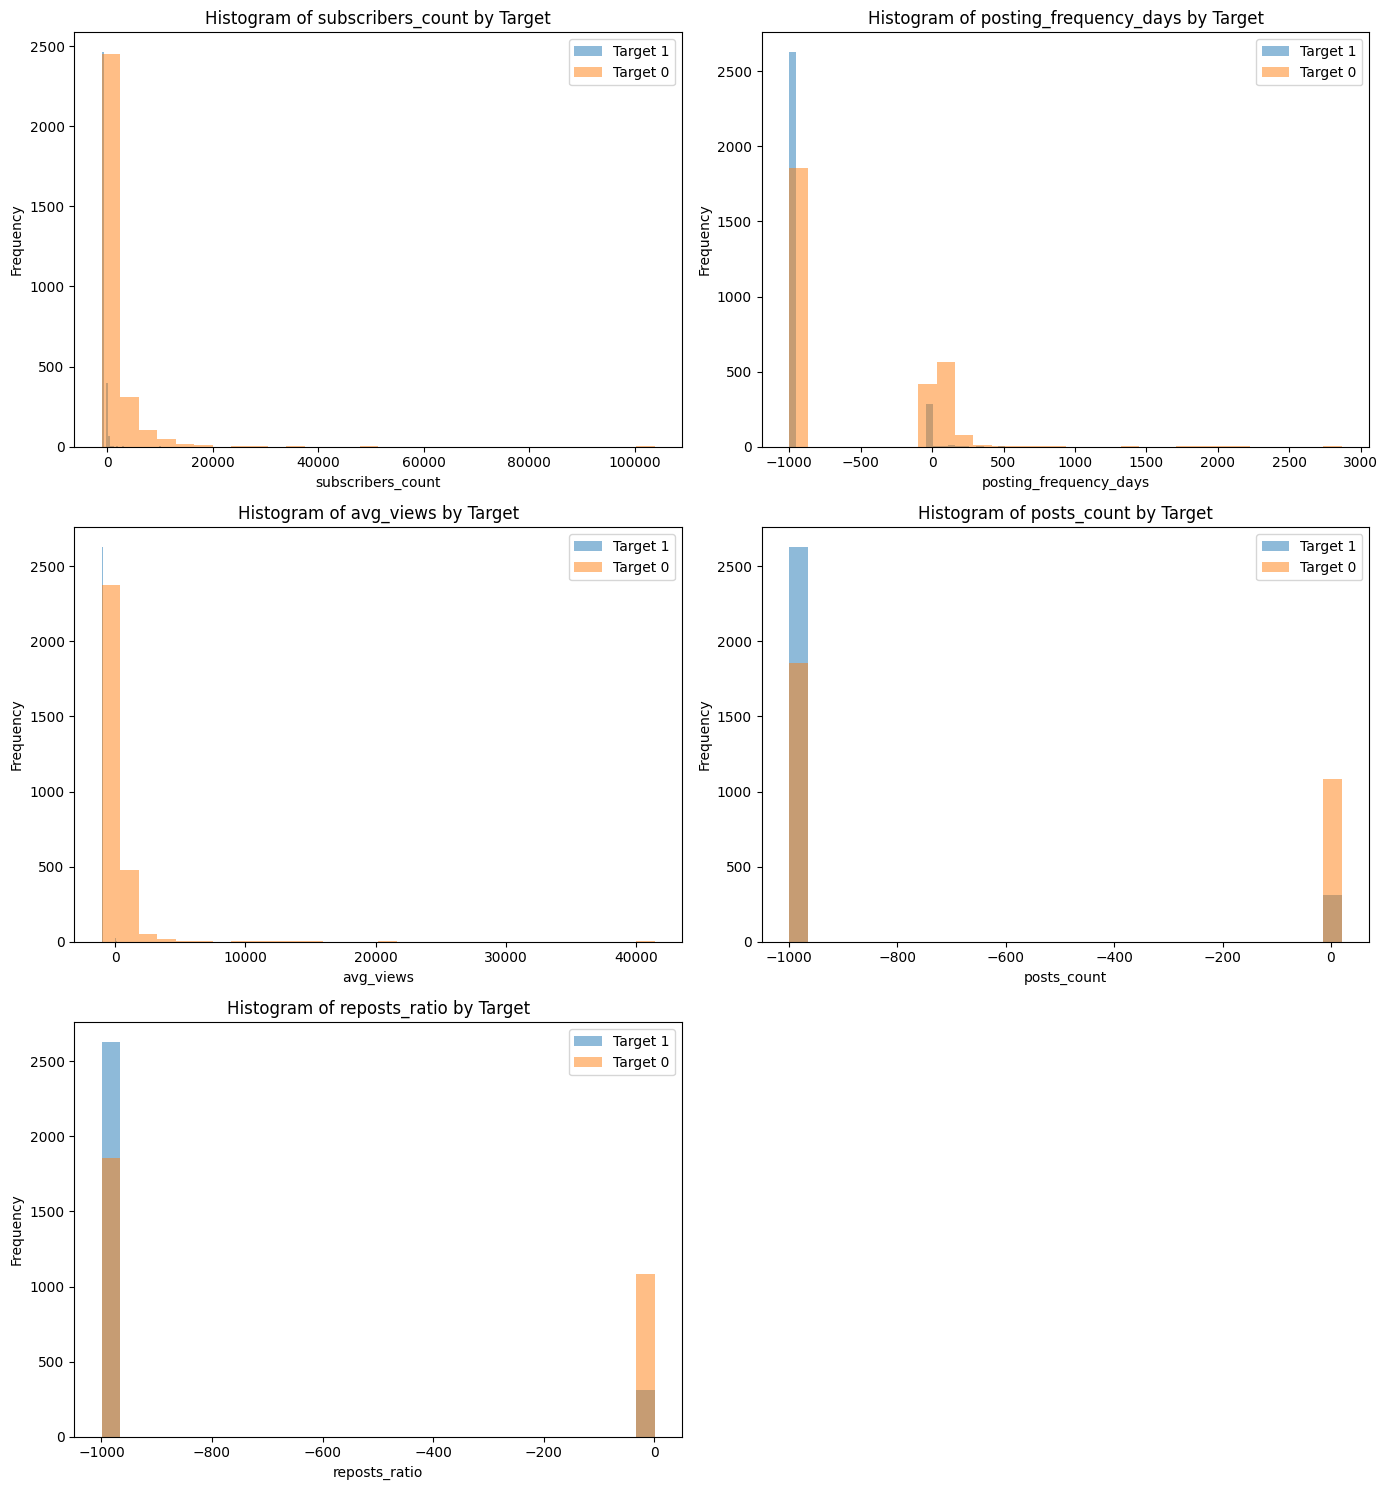

In [16]:


# Ensure eda_df is defined and contains the required columns
features = ['subscribers_count', 'posting_frequency_days', 'avg_views', 'posts_count', 'reposts_ratio']

# Set up plot layout
n = len(features)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Plot histograms for each feature grouped by target
for i, feature in enumerate(features):
    for label in eda_df['target'].unique():
        subset = eda_df[eda_df['target'] == label]
        axes[i].hist(subset[feature].dropna(), bins=30, alpha=0.5, label=f'Target {label}')
    
    axes[i].set_title(f'Histogram of {feature} by Target')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Bots  typically have a low subscriber count, have a much higher posting frequency rate, more views, more posts, and reposts. We can see bots generally have significantly more activity than users.

In [17]:
['has_status',
 
 'has_occupation',
 'has_website',

 'has_birth_date',
 'has_nickname',
 'gender',
 'access_to_closed_profile',

 'has_mobile',
 'has_photo',

 'has_maiden_name',
 'occupation_type_university',

 'all_posts_visible']

['has_status',
 'has_occupation',
 'has_website',
 'has_birth_date',
 'has_nickname',
 'gender',
 'access_to_closed_profile',
 'has_mobile',
 'has_photo',
 'has_maiden_name',
 'occupation_type_university',
 'all_posts_visible']

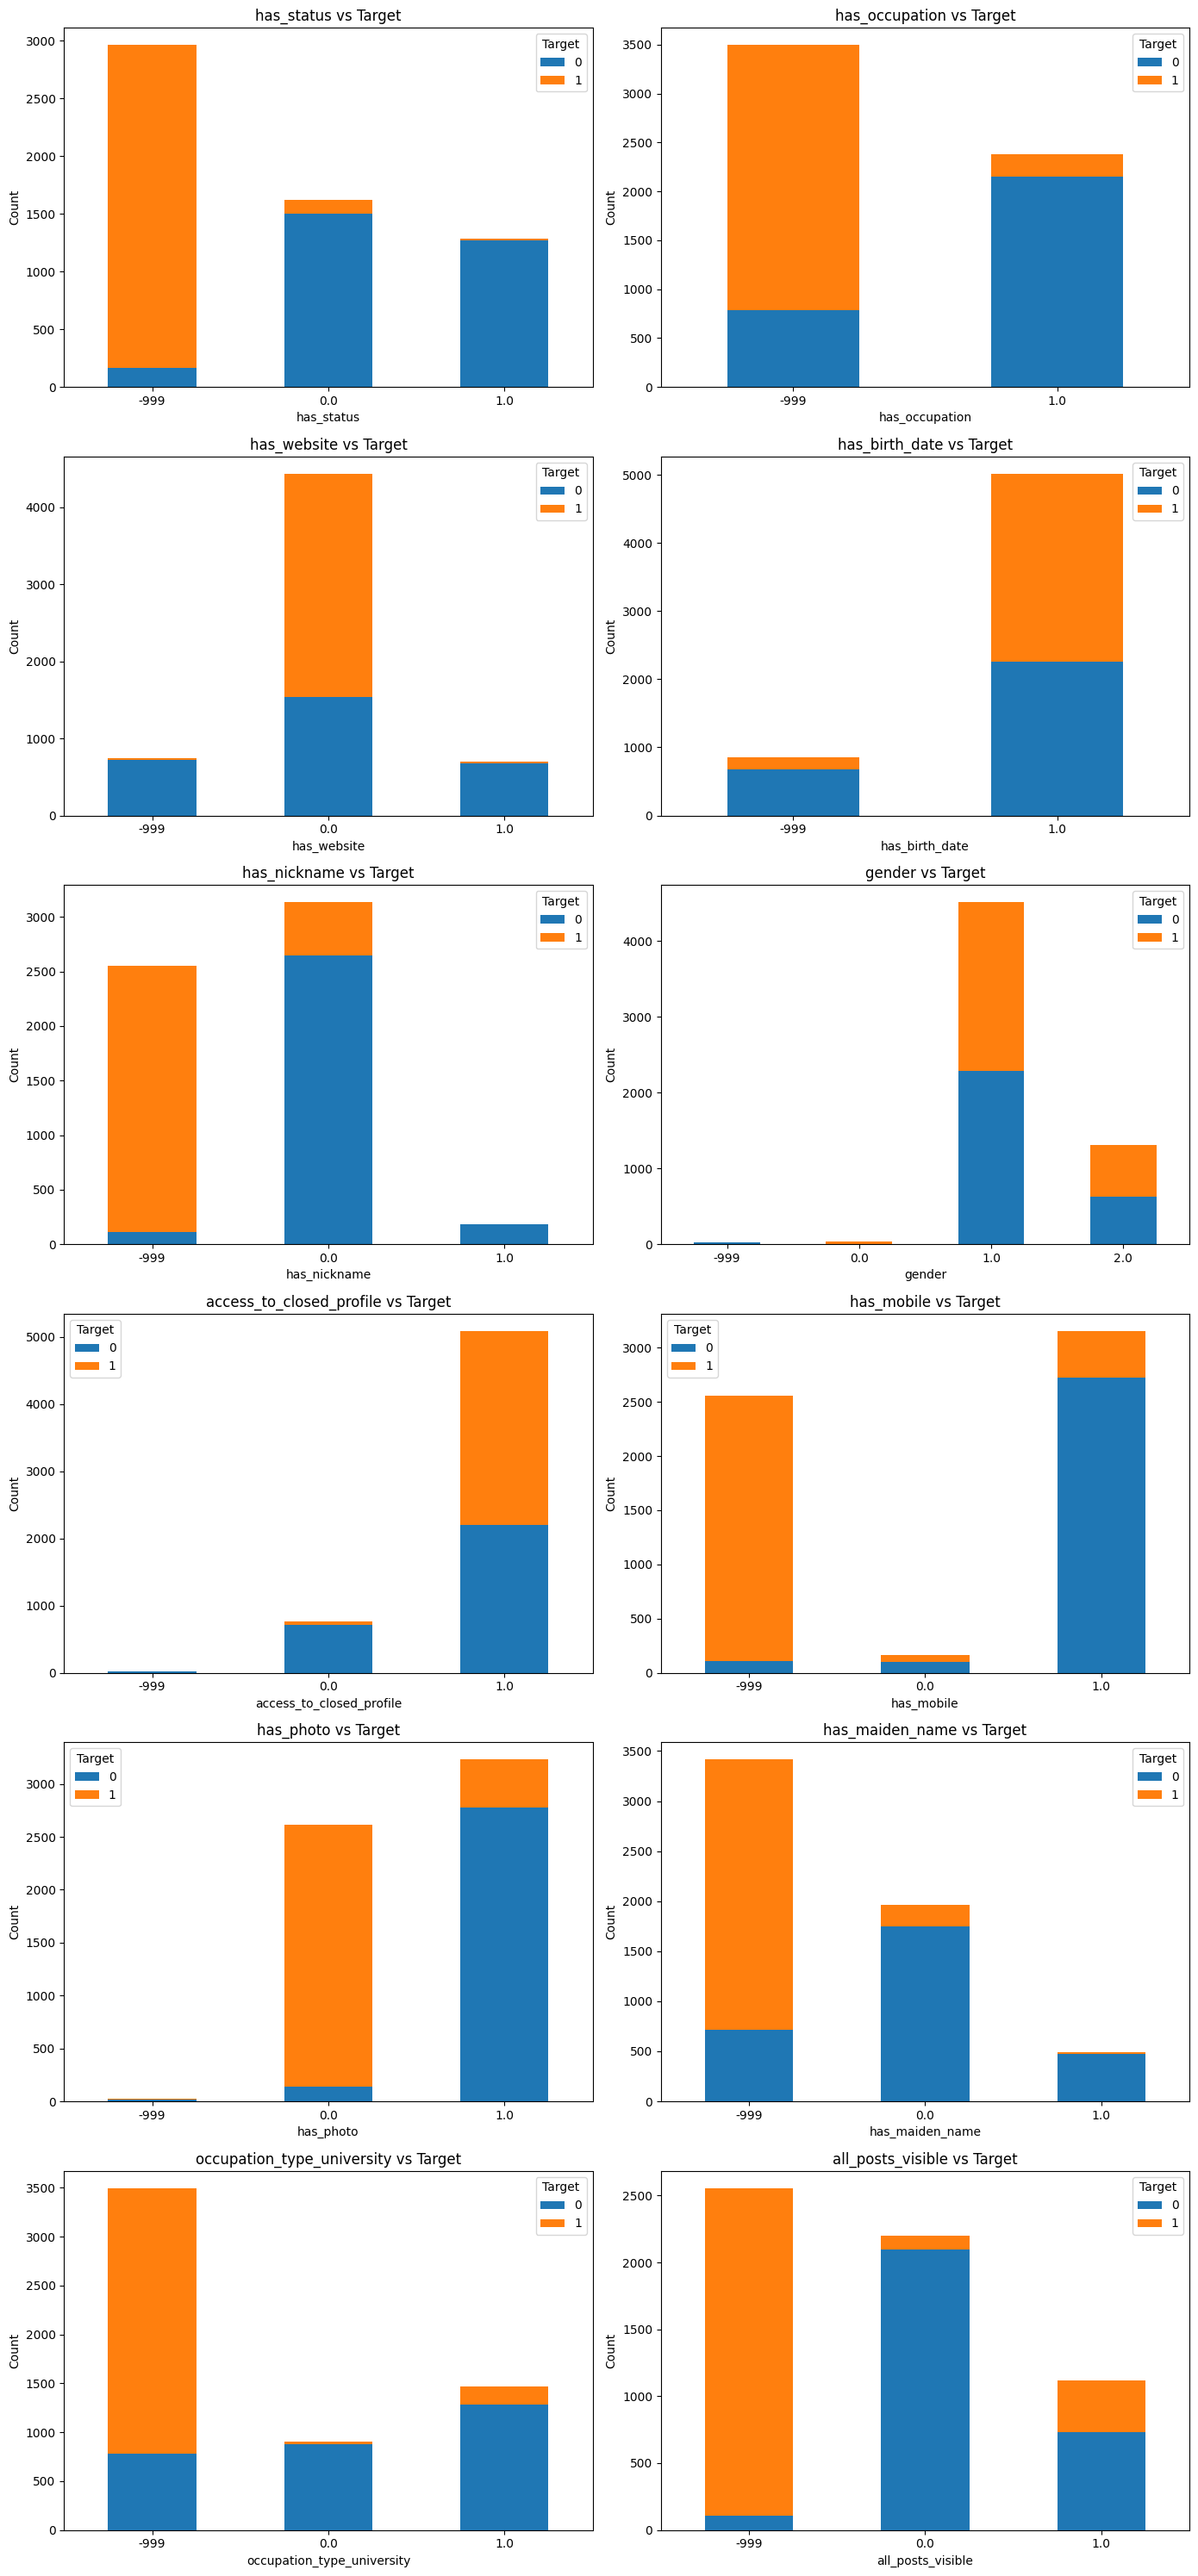

In [18]:
import matplotlib.pyplot as plt
import math

barplot_cols = ['has_status',
                 'has_occupation',
                 'has_website',
                 'has_birth_date',
                 'has_nickname',
                 'gender',
                 'access_to_closed_profile',
                 'has_mobile',
                 'has_photo',
                 'has_maiden_name',
                 'occupation_type_university',
                 'all_posts_visible']
# Layout setup: 2 plots per row
n = len(barplot_cols)
cols = 2
rows = math.ceil(n / cols)

# Set up the figure
fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()  # flatten even if it's 1D for consistency

# Loop through each feature
for i, feature in enumerate(barplot_cols):
    plot_data = df.groupby([feature, 'target']).size().unstack(fill_value=0)

    plot_data.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{feature} vs Target')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Target')
    axes[i].tick_params(axis='x', rotation=0)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Real users have a display photo, not all their posts are visible, has a mobile device, has a website, and has occupation information.

Bots have most if not all their posts visible, has a maiden name, doesnt have a display photo,and has a nickname.

# Final Summary

Bots typically exhibit high activity patterns: they tend to have low subscriber counts but higher posting frequency, more views, a greater number of posts, and more reposts than real users. These behaviors suggest automated or scripted activity intended to mimic engagement. Additionally, bots are more likely to have all posts visible, lack a display photo, and often fill out fields such as nickname, maiden name, or status, likely to appear legitimate through over-completion of profile fields. Missing or placeholder values (i.e., -999) are less common among bots, further suggesting that they follow templated completeness.

In contrast, real users exhibit more natural and moderate behaviors. They are more likely to have a display photo, less post visibility, and higher subscriber counts, despite showing less overall activity. Users often leave optional fields blank, such as status, maiden name, or nickname, and are more likely to include authentic signals like occupation, website, mobile presence, and university affiliations. These subtle distinctions between over-completion (bots) and selective omission (users) form a strong basis for feature-based classification.